In [1]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [3]:
from multiprocessing import Pool
import multiprocessing
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from functools import partial
import folium

import bus.analyzer as anz
import bus.stay as stay

In [4]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

station_usage_df = anz.parallel_load_total_usage_df(input_path_list, core=8)

# 데이터 로드
user_df = anz.load_user_df()
station_df = anz.load_station_df()
cluster_df = anz.load_cluster_df()
cluster_station_df = anz.load_cluster_station_df()

# 정류장 간 이동 데이터 -> 군집간 이동 데이터
cluster_usage_df = stay.create_cluster_usage_df(station_usage_df, cluster_station_df)

In [5]:
# 체류시간 추출
walk_df = stay.get_walk_df(cluster_usage_df)

In [6]:
# 결측값 제거
walk_df = walk_df.dropna()

In [7]:
# 관광객 데이터 추출
tourist_walk_df = stay.fillter_usage_df(walk_df, user_df, tourist=True)

In [8]:
# 관광객 체류시간 데이터 추출
walk_time_count_df = stay.analyze_walk_time_count(tourist_walk_df)

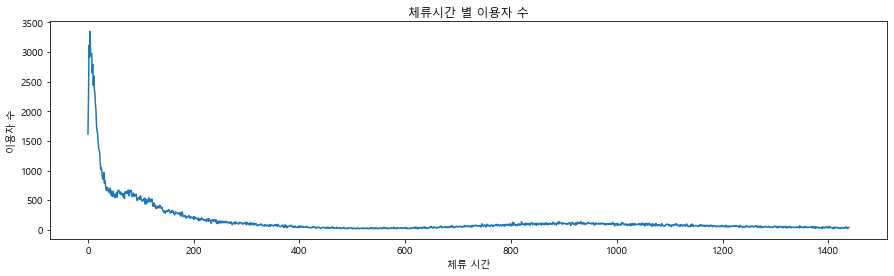

In [9]:
# 체류시간 데이터 시각화
x = walk_time_count_df['stay_time'].head(10000)
y = walk_time_count_df['num'].head(10000)
stay.draw_walk_time_count(x, y)

In [10]:
# position column 추가
tourist_walk_df = stay.set_position_columns(tourist_walk_df, cluster_df)

In [11]:
import math
    
def set_distance_column(df):
    d = math.pi*2*6371000/360
    
    df['dist_x'] = df['geton_cluster_longitude'] - df['getoff_cluster_longitude']
    df['dist_y'] = df['geton_cluster_latitude'] - df['getoff_cluster_latitude']
    
    df['dist_x'] = df['dist_x'].apply(lambda x : abs(x))
    df['dist_y'] = df['dist_y'].apply(lambda x : abs(x))
    
    df['distance'] = (df['dist_x']*df['dist_x'] + df['dist_y']*df['dist_y'])**0.5*d
    df['distance'] = df['distance'].apply(lambda x : int(x))
    df['distance'] = df['distance']
    return df

tourist_walk_df = set_distance_column(tourist_walk_df)

In [24]:
def get_walk_distance_df(walk_df):
    walk_df = walk_df['distance'].value_counts()
    walk_df = pd.DataFrame(walk_df)
    walk_df = walk_df.reset_index().rename(columns = {'index':'distance', 'distance':'num'})
    walk_df = walk_df.sort_values('distance')
    seletor = walk_df.columns
    walk_df = walk_df.reset_index()[seletor]
    return walk_df

walk_distance_df = get_walk_distance_df(tourist_walk_df)

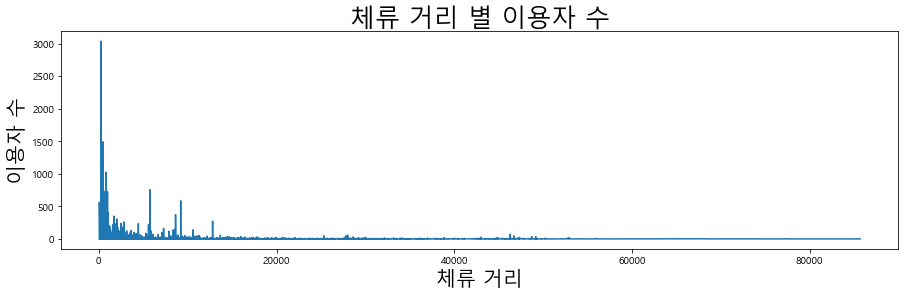

In [23]:
from matplotlib import pyplot as plt
def draw_walk_distance_count(x, y):
    plt.rcParams["figure.figsize"] = (15,4)
    plt.plot(x, y)
    plt.title('체류 거리 별 이용자 수', fontsize=25)
    plt.xlabel("체류 거리", fontsize=20)
    plt.ylabel("이용자 수", fontsize=20)
    plt.show()
    
x = walk_distance_df['distance'][1:]
y = walk_distance_df['num'][1:]
draw_walk_distance_count(x, y)

In [29]:
walk_distance_df["a"] = walk_distance_df["distance"]*walk_distance_df["num"]


walk_distance_df["a"].sum()/walk_distance_df["num"].sum()

2429.2741608012993

In [15]:
tourist_walk_df['num'] = 1
# tourist_walk_df[['stay_time', 'distance']].groupby(by=['stay_time', 'distance']).count().reset_index()
a = tourist_walk_df[['stay_time', 'distance', 'num']].groupby(by=['stay_time', 'distance']).count().reset_index()


8166


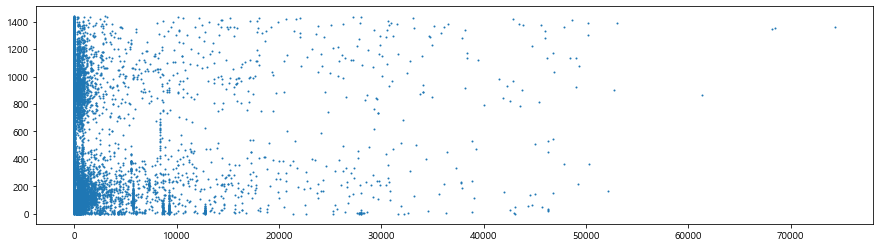

In [16]:


b = a[a['num']>=3]
print(len(b))
x = b['distance']
y = b['stay_time']
plt.scatter(x, y, s=1)

In [17]:
a = tourist_walk_df
print(len(a))
b = a[a['distance'] < 10000]
print(len(b))
c = a[a['stay_time'] < 600]
print(len(c))
bc = b[a['stay_time'] < 600]
print(len(bc))

221640
205827
164186
155142


<ipython-input-17-3af41453ba0c>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bc = b[a['stay_time'] < 600]


In [18]:
tourist_walk_df

,user_id,getoff_cluster_id,getoff_datetime,geton_cluster_id,geton_datetime,stay_time,geton_cluster_longitude,geton_cluster_latitude,getoff_cluster_longitude,getoff_cluster_latitude,dist_x,dist_y,distance,num
0,00015b56a3bbaf374a77b817350da65a46f96a9a682848...,800.0,2019-06-01 09:35:27,1.0,2019-06-01 11:44:38,129,126.514680,33.499755,126.507000,33.500130,0.007680,0.000375,854,1
1,1f97062f7421827b86f6edb5abc0b135d0b6d78c97a170...,800.0,2019-06-25 09:53:48,1.0,2019-06-25 11:35:55,102,126.514680,33.499755,126.507000,33.500130,0.007680,0.000375,854,1
2,27ad6c077cec12261e12107b28580afc2f151c565a4f55...,800.0,2019-06-11 16:46:44,1.0,2019-06-11 17:50:28,63,126.514680,33.499755,126.507000,33.500130,0.007680,0.000375,854,1
3,3341245d000e330ca253d8e4b85f2e56ebc97162508319...,800.0,2019-06-11 16:46:32,1.0,2019-06-11 17:50:18,63,126.514680,33.499755,126.507000,33.500130,0.007680,0.000375,854,1
4,4b8bd25158e64ac0b943cf8028c3fe35ebdc2ff8d207d2...,800.0,2019-07-16 09:42:54,1.0,2019-07-16 11:20:22,97,126.514680,33.499755,126.507000,33.500130,0.007680,0.000375,854,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221635,d32c7480514e47613d7a79b5246b7459a7d4a864b1848b...,1353.0,2019-07-14 10:25:07,1353.0,2019-07-14 11:26:40,61,126.795360,33.332910,126.795360,33.332910,0.000000,0.000000,0,1
221636,d69e523ed334c0eea0e9c9ede0aed984f7c20cfcada7f7...,1336.0,2019-07-03 15:33:54,1318.0,2019-07-03 16:00:15,26,126.773905,33.350195,126.783320,33.346880,0.009415,0.003315,1109,1
221637,e7059e3dd3e77afe9db251343647017b21864924355633...,1401.0,2019-07-02 12:32:25,1334.0,2019-07-02 12:52:28,20,126.827200,33.326925,126.789945,33.344060,0.037255,0.017135,4559,1
221638,ee796a3984a4f844383066e6ffc3ab1a3d55a9519e0e4d...,100.0,2019-07-16 12:20:53,100.0,2019-07-16 14:00:17,99,126.610907,33.469870,126.610907,33.469870,0.000000,0.000000,0,1


In [19]:
x1 = 126.553375
y1 = 33.478634
x2 = 126.507000
y2 = 33.500130
dist = ((x1-x2)**2+(y1-y2)**2)**(1/2) *6500000/360
print(dist)
a = anz.load_cluster_df()
selector = list(a.columns)
a['dist1_x'] = (a['cluster_longitude'] - x1)**2
a['dist1_y'] = (a['cluster_latitude'] - y1)**2
a['dist2_x'] = (a['cluster_longitude'] - x2)**2
a['dist2_y'] = (a['cluster_latitude'] - y2)**2

a['dist1'] = (a['dist1_x'] + a['dist1_y'])**(1/2)
a['dist2'] = (a['dist2_x'] + a['dist2_y'])**(1/2)
a['dist'] = a['dist1'] + a['dist2']
a['dist'] = a['dist']*6500000/360
a['dist'] = a['dist'].apply(lambda x : int(x))
selector.append("dist")
a = a[selector]
a = a.sort_values(by="dist")
a[a['dist']<dist*1.2]

922.9053802597195


,cluster_id,cluster_group,cluster_target,cluster_longitude,cluster_latitude,tour_geton_usage,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage,dist
800,800.0,제주시,800.0,126.507000,33.500130,280.0,7024.0,489.0,4954.0,12747.0,922
346,346.0,제주시,346.0,126.519750,33.494835,7.0,2353.0,7.0,2328.0,4695.0,923
283,283.0,제주시,283.0,126.532655,33.489320,15.0,5547.0,6.0,3994.0,9562.0,923
183,183.0,제주시,183.0,126.521475,33.492250,22.0,19289.0,16.0,14845.0,34172.0,923
166,166.0,제주시,166.0,126.526990,33.492175,55.0,43880.0,70.0,26687.0,70692.0,923
...,...,...,...,...,...,...,...,...,...,...,...
300,300.0,제주시,300.0,126.540265,33.502785,6.0,4236.0,14.0,1976.0,6232.0,1098
24,24.0,제주시,24.0,126.536315,33.504888,418.0,45886.0,357.0,37092.0,83753.0,1101
365,365.0,제주시,365.0,126.511875,33.481175,2.0,2942.0,1.0,1223.0,4168.0,1104
342,342.0,제주시,342.0,126.530835,33.507120,20.0,2627.0,30.0,1179.0,3856.0,1104
